### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [3]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [4]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [5]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [6]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [7]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [8]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [9]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x000001D67F5D3670>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [10]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [55]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))

for dm in [0, 5, 10]:
    for location in [0, 1, 2, 3, 4]:
        for ews_days in [2, 4]:
            pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days},
                                          name=f"Dike_{dm}dm_RfR_{location}_EWS_{ews_days}d"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [56]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(dike_model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 3 workers
[MainProcess/INFO] performing 10 scenarios * 30 policies * 1 model(s) = 300 experiments
  0%|▏                                         | 1/300 [00:00<02:11,  2.27it/s]Traceback (most recent call last):
  File "C:\Users\cwouw\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 244, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\cwouw\anaconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "C:\Users\cwouw\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 279, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\cwouw\anaconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 258, in _stor

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [57]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
0,2.202897e+08,930892016,NaN,NaN,NaN,9.308920e+08,1.151182e+09,Policy_Dike_0dm_RfR_0_EWS_2d
1,7.045947e+08,0,84600000.0,34503.913699,0.097440,8.463450e+07,7.892292e+08,Policy_Dike_0dm_RfR_0_EWS_2d
2,1.855282e+09,0,84600000.0,78062.826028,0.483250,8.467806e+07,1.939960e+09,Policy_Dike_0dm_RfR_0_EWS_2d
3,7.674635e+08,0,84600000.0,31817.700224,0.217668,8.463182e+07,8.520953e+08,Policy_Dike_0dm_RfR_0_EWS_2d
4,1.361875e+08,0,84600000.0,5927.369947,0.018815,8.460593e+07,2.207934e+08,Policy_Dike_0dm_RfR_0_EWS_2d
...,...,...,...,...,...,...,...,...
295,2.620728e+09,44215020,256100000.0,34031.056208,0.209004,3.003491e+08,2.921078e+09,Policy_Dike_10dm_RfR_4_EWS_4d
296,2.045003e+09,44215020,256100000.0,36498.264526,0.210169,3.003515e+08,2.345355e+09,Policy_Dike_10dm_RfR_4_EWS_4d
297,5.402135e+08,44215020,256100000.0,26065.309771,0.046954,3.003411e+08,8.405546e+08,Policy_Dike_10dm_RfR_4_EWS_4d
298,8.819696e+08,44215020,256100000.0,48340.991635,0.076871,3.003634e+08,1.182333e+09,Policy_Dike_10dm_RfR_4_EWS_4d


In [58]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [59]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Number of Deaths                      \
                                                   mean       min       max   
policy                                                                        
Policy_Dike_0dm_RfR_0_EWS_2d                   0.210209  0.018815  0.502557   
Policy_Dike_0dm_RfR_0_EWS_4d                   0.153988  0.015052  0.402045   
Policy_Dike_0dm_RfR_1_EWS_2d                   0.196901  0.018815  0.525442   
Policy_Dike_0dm_RfR_1_EWS_4d                   0.157521  0.015052  0.420353   
Policy_Dike_0dm_RfR_2_EWS_2d                   0.176565  0.013510  0.438111   
Policy_Dike_0dm_RfR_2_EWS_4d                   0.141252  0.010808  0.350488   
Policy_Dike_0dm_RfR_3_EWS_2d                   0.220781  0.016476  0.580514   
Policy_Dike_0dm_RfR_3_EWS_4d                   0.176625  0.013181  0.464411   
Policy_Dike_0dm_RfR_4_EWS_2d                   0.249012  0.019624  0.609182   
Policy_Dike_0dm_RfR_4_EWS_4d                   0.199209  0.015699  0.487345   
Policy_Dike_10dm_RfR_0_EWS_2d                  0.058541  0.006676  0.215558   
Policy_Dike_10dm_RfR_0_EWS_4d                  0.046833  0.005341  0.172446   
Policy_Dike_10dm_RfR_1_EWS_2d                  0.063112  0.006676  0.215751   
Policy_Dike_10dm_RfR_1_EWS_4d                  0.050489  0.005341  0.172601   
Policy_Dike_10dm_RfR_2_EWS_2d                  0.130005  0.006635  0.261255   
Policy_Dike_10dm_RfR_2_EWS_4d                  0.104004  0.005308  0.209004   
Policy_Dike_10dm_RfR_3_EWS_2d                  0.124588  0.003379  0.262583   
Policy_Dike_10dm_RfR_3_EWS_4d                  0.099670  0.002704  0.210067   
Policy_Dike_10dm_RfR_4_EWS_2d                  0.135907  0.017047  0.262711   
Policy_Dike_10dm_RfR_4_EWS_4d                  0.108726  0.013638  0.210169   
Policy_Dike_5dm_RfR_0_EWS_2d                   0.070641  0.009038  0.215558   
Policy_Dike_5dm_RfR_0_EWS_4d                   0.056513  0.007231  0.172446   
Policy_Dike_5dm_RfR_1_EWS_2d                   0.071052  0.009038  0.215751   
Policy_Dike_5dm_RfR_1_EWS_4d                   0.056841  0.007231  0.172601   
Policy_Dike_5dm_RfR_2_EWS_2d                   0.130005  0.006635  0.261255   
Policy_Dike_5dm_RfR_2_EWS_4d                   0.104004  0.005308  0.209004   
Policy_Dike_5dm_RfR_3_EWS_2d                   0.124649  0.003986  0.262583   
Policy_Dike_5dm_RfR_3_EWS_4d                   0.099719  0.003189  0.210067   
Policy_Dike_5dm_RfR_4_EWS_2d                   0.136143  0.019402  0.262711   
Policy_Dike_5dm_RfR_4_EWS_4d                   0.108914  0.015522  0.210169   

                                                  Expected Annual Damage  \
                                    q05       q95                   mean   
policy                                                                     
Policy_Dike_0dm_RfR_0_EWS_2d   0.037742  0.494834           1.006345e+09   
Policy_Dike_0dm_RfR_0_EWS_4d   0.020149  0.395095           1.006345e+09   
Policy_Dike_0dm_RfR_1_EWS_2d   0.028832  0.506455           1.052153e+09   
Policy_Dike_0dm_RfR_1_EWS_4d   0.023066  0.405164           1.052153e+09   
Policy_Dike_0dm_RfR_2_EWS_2d   0.040434  0.357858           1.391143e+09   
Policy_Dike_0dm_RfR_2_EWS_4d   0.032347  0.286286           1.391143e+09   
Policy_Dike_0dm_RfR_3_EWS_2d   0.029761  0.481074           1.529563e+09   
Policy_Dike_0dm_RfR_3_EWS_4d   0.023809  0.384859           1.529563e+09   
Policy_Dike_0dm_RfR_4_EWS_2d   0.056722  0.539887           1.676137e+09   
Policy_Dike_0dm_RfR_4_EWS_4d   0.045378  0.431910           1.676137e+09   
Policy_Dike_10dm_RfR_0_EWS_2d  0.010244  0.162405           5.099830e+08   
Policy_Dike_10dm_RfR_0_EWS_4d  0.008195  0.129924           5.099830e+08   
Policy_Dike_10dm_RfR_1_EWS_2d  0.011253  0.162511           5.547898e+08   
Policy_Dike_10dm_RfR_1_EWS_4d  0.009002  0.130009           5.547898e+08   
Policy_Dike_10dm_RfR_2_EWS_2d  0.007730  0.260587           1.212769e+09   
Policy_Dike_10dm_RfR_2_EWS_4d  0.006184  0.208470     

In [60]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

In [61]:
TCA_df.columns

MultiIndex([('Expected Number of Deaths', 'mean'),
            ('Expected Number of Deaths',  'min'),
            ('Expected Number of Deaths',  'max'),
            ('Expected Number of Deaths',  'q05'),
            ('Expected Number of Deaths',  'q95'),
            (   'Expected Annual Damage', 'mean'),
            (   'Expected Annual Damage',  'min'),
            (   'Expected Annual Damage',  'max'),
            (   'Expected Annual Damage',  'q05'),
            (   'Expected Annual Damage',  'q95'),
            (              'Total Costs', 'mean'),
            (         'Cost plus Damage', 'mean'),
            (         'Cost plus Damage',  'min'),
            (         'Cost plus Damage',  'max'),
            (         'Cost plus Damage',  'q05'),
            (         'Cost plus Damage',  'q95')],
           )

### Plots

TODO: Make make some nice Seaborn plots?

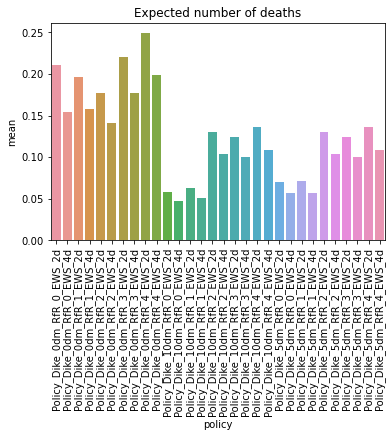

<Figure size 432x288 with 0 Axes>

In [62]:
#TCA_df["Expected Number of Deaths"]["mean"].plot.bar()
ND = sns.barplot(x= TCA_df.index , y = TCA_df["Expected Number of Deaths"]["mean"], data = TCA_df)
ND.set(title='Expected number of deaths')
#ND.fig.suptitle('Expected number of deaths')
plt.xticks(rotation=90)
plt.show()
plt.savefig('number of deaths.png')

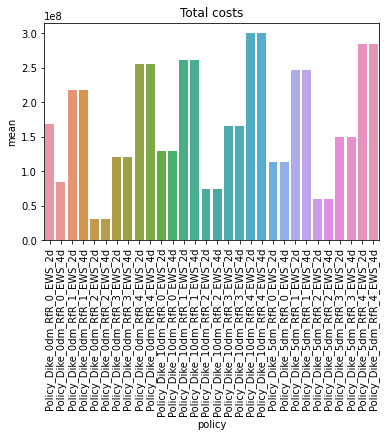

<Figure size 432x288 with 0 Axes>

In [63]:
#TCA_df["Total Costs"]["mean"].plot.bar()
TC = sns.barplot(x= TCA_df.index , y = TCA_df["Total Costs"]["mean"], data = TCA_df)
TC.set(title='Total costs')
plt.xticks(rotation=90)
plt.show()
plt.savefig('total costs.png')

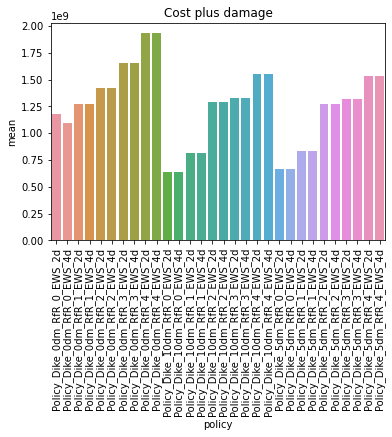

<Figure size 432x288 with 0 Axes>

In [64]:
#TCA_df["Cost plus Damage"]["mean"].plot.bar()
CpD = sns.barplot(x= TCA_df.index , y = TCA_df["Cost plus Damage"]["mean"], data = TCA_df)
CpD.set(title='Cost plus damage')
plt.xticks(rotation=90)
plt.show()
plt.savefig('cost plus damage.png')